# ARIM情報活用講座：　ケモメトリックス 
# 海洋環境にあるマイクロプラスチックのラマン分光の参照スペクトル

## データセット
Duke大学Emily A . Millerらの論文[1]で公開されている海洋環境に関連する主要なポリマーのオープンアクセスの参照ライブラリです。このライブラリには、以下のカテゴリー別の参照スペクトルが含まれています。

（a）メーカーから新しく入手した未使用のポリマー（n = 40）  
（b）消費者による使用済みのポリマー、海洋環境に漂着したポリマー、農業および漁業源から収集された劣化・分解したポリマー（n = 22）  
（c）多様な海洋生物、栄養素、組織の生態由来ポリマー（n = 17）  

このデータセットの特徴は、未使用および劣化（分解）したポリマーだけでなく、異なる分類群の生態由来のポリマーも含まれていることです。対象データ（プラスチック）に加えて非対象データ（非プラスチック）も提供することで、広範なカテゴリの分類や識別の精度を向上させるとしています。

<img src="./img/image.png" width="50%">

--- 
[1] Emily A . Miller, Kevan M. Yamahara, Chris French, Neil Spingarn, James M. Birch & Kyle S. Van Houtan "A Raman spectral reference library of potential anthropogenic and biological ocean polymers", Scientific Data. 9, Article number: 780 (2022) https://doi.org/10.1038/s41597-022-01883-5

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install ramanspy
!pip install adjustText

!git clone https://github.com/ARIM-Academy/Practice_2.git
%cd Practice_2

## 1.ライブラリのインポート

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ラマンの前処理
import ramanspy as rp

# 警告を無視
from warnings import filterwarnings
filterwarnings('ignore')

## 2. util関数の設定

### 2.1 csv読み取りと保存の関数
一括処理のための関数を２つ準備します。スペクトルの前処理を一括して行う`read_csv()`関数は論文で提供されているラマンスペクトル(csv)を読み取り、**ramanSPy**で処理ができるオブジェクト（変数）へ変換します。

In [2]:
def read_csv(csv_filename, skiprows):
    
    """
    概要: 入力データ（csv）から簡易ヘッダー付きスペクトルデータ（csv）で出力する
    @param csv_filename : 入力ファイル名
    @param skiprows : ヘッダーでのスキップする行数
    @return raman_spectrum： ramasSPyのオブジェクト
    """

    data = pd.read_csv(csv_filename, skiprows=skiprows)

    x = data["Raman Shift / cm-1"]
    y = data["INT"]

    raman_spectrum = rp.Spectrum(y, x)

    return raman_spectrum

### 2.2 保存関数
スペクトルの前処理を行った後のスペクトルを  `dump_csv()`関数でcsv保存します。

In [3]:
HEADER = "wavenumber, intensity"

def dump_csv(output_csv, data):
    """
    概要: 入力データ（csv）から簡易ヘッダー付きスペクトルデータ（csv）で出力する
    @param output_csv : 出力ファイル名
    @param csv_data : 数値部のデータ
    @return None.
    """
    x = data.spectral_axis
    y = data.spectral_data
    
    spectrum = np.c_[x,y]
    
    np.savetxt(output_csv,
               spectrum,
               delimiter=',', 
               header = HEADER
              )

## 3.スペクトルデータの読み込み
### ファイルの読み取り
指定されたディレクトリ 'data' 内の .csv 全ファイルを取得し、それらのファイルパスをファイル名の昇順でソートしたリストを生成します。このリストは`files`の変数で格納され、後続でcsvファイルの一括処理を行います。

In [4]:
files = sorted(Path('data').glob('*.csv'))

In [5]:
len(files)

74

## 4. 前処理（Preprocess）
ベースライン補正などのラマンスペクトルの前処理は、RamanSPyライブラリに含まれているメソッドを使います。ここではdataフォルダーのスペクトルを逐次的に読み出し、前処理を行ったあと、その処理済スペクトルをcsvで保存します。

### 前処理のパイプライン化
Duke大学Emily A . Millerらの論文[1]に沿った前処理のパイプラインです。ramanSPyのpreprocessingモジュールを使い、preprossesing は、以下のように前処理を行います。
* ベースライン補正
* 宇宙線削除
* Savitzky-Golayフィルターによる平滑化（ノイズ除去）
* データの正規化（Min-Maxスケーリング）
* クロッピング（指定範囲内）

In [6]:
# ラマンスペクトルのクロッピングの範囲指定
CROP = (200, 3400)

# Savitzky-Golayフィルターのウィンドウ幅
WINDOWS_LENGTH = 15

# Savitzky-Golayフィルターの多項式項
POLYORDER = 7

def preprossesing (spectrum):
    
    pipeline = rp.preprocessing.Pipeline([
        #rp.preprocessing.baseline.ASPLS(),                                 # ベースライン補正
        #rp.preprocessing.despike.WhitakerHayes(),                          # 宇宙線削除
        rp.preprocessing.denoise.SavGol(window_length=WINDOWS_LENGTH, polyorder=POLYORDER),    # Savitzky-Golayフィルター
        rp.preprocessing.normalise.MinMax(),                               # 規格化 standard normal variate（SNV）
        rp.preprocessing.misc.Cropper(region=(CROP))                       # クロッピング
        ])

    correct_spectrum = pipeline.apply(spectrum)

    return correct_spectrum

### 前処理と結果の保存
複数のスペクトルデータファイルを読み込み、前処理を行い、処理結果を保存し、最終的にデータ行列とサンプル名のリストを作成します。    ）。

In [7]:
%%time

data = []
sample_name = []
OUT_DIR =Path("output")

for csvfile in files:

    #スペクトルファイルの読み込み
    spectrum = read_csv(csvfile, skiprows = 1)
    
    # 前処理のパイプライン
    correct = preprossesing(spectrum)

    # 前処理済スペクトルの保存
    output_csv = OUT_DIR.joinpath(csvfile.name[:-4] + "_correct.csv")
    dump_csv(output_csv, correct)

    #データ行列の作成
    data.append(correct.spectral_data)
    sample_name.append(csvfile.name[:-4])

CPU times: total: 250 ms
Wall time: 2.1 s


## 5. クラスタリング分析

前処理されたすべてのスペクトルをデータフレームで統合したdfオブジェクトを作成します。このデータ行列（データフレーム）から、ポリマーの類似性を階層クラスタリング分析（HCA）やk-mean法によるクラスタリングから判定します。

In [8]:
df = pd.DataFrame(data, 
                  index = sample_name, 
                  columns = correct.spectral_axis
                 )
df

,200.93,201.90,202.86,203.82,204.79,205.75,206.72,207.68,208.65,209.61,...,3390.61,3391.58,3392.54,3393.51,3394.47,3395.44,3396.40,3397.36,3398.33,3399.29
24544r56_1 PLAS 214 532 nm,0.023219,0.023977,0.024241,0.024540,0.025201,0.026065,0.026503,0.025997,0.024423,0.022214,...,0.006855,0.006848,0.006706,0.006465,0.006116,0.005821,0.005455,0.005130,0.005127,0.005352
24544r57_1 PLAS 216 532 nm,0.016013,0.015758,0.015459,0.015547,0.016242,0.017467,0.018782,0.019645,0.019866,0.019549,...,0.008341,0.008306,0.008265,0.008268,0.008252,0.008188,0.008136,0.008134,0.008164,0.008268
24544r58_1 PLAS 218 532 nm,0.008972,0.008841,0.008668,0.008515,0.008448,0.008524,0.008703,0.008877,0.008910,0.008761,...,0.006469,0.006682,0.006690,0.006458,0.006100,0.005785,0.005613,0.005569,0.005636,0.005726
24544r61_1 PLAS 233 532 nm,0.011943,0.011178,0.010271,0.009745,0.009952,0.010904,0.012050,0.012703,0.012467,0.011442,...,0.010437,0.010091,0.010021,0.010315,0.010577,0.010516,0.010206,0.009856,0.009669,0.009668
24544r62_1 PLAS 257 532 nm,0.079232,0.077349,0.074683,0.074144,0.079178,0.091641,0.109552,0.127301,0.138566,0.140381,...,0.113612,0.103745,0.090602,0.080226,0.074697,0.072641,0.070556,0.068516,0.069559,0.075180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLAS 233 532 nm,0.011943,0.011178,0.010271,0.009745,0.009952,0.010904,0.012050,0.012703,0.012467,0.011442,...,0.010437,0.010091,0.010021,0.010315,0.010577,0.010516,0.010206,0.009856,0.009669,0.009668
PLAS 257 532 nm,0.079232,0.077349,0.074683,0.074144,0.079178,0.091641,0.109552,0.127301,0.138566,0.140381,...,0.113612,0.103745,0.090602,0.080226,0.074697,0.072641,0.070556,0.068516,0.069559,0.075180
PLAS 258 532 nm,0.026544,0.026298,0.025841,0.025894,0.026920,0.028780,0.030693,0.031738,0.031568,0.030412,...,0.011425,0.011128,0.010560,0.009901,0.009475,0.009206,0.008639,0.007843,0.007341,0.007477
PLAS 259 532 nm,0.053085,0.048794,0.042766,0.040109,0.045310,0.059521,0.077511,0.090392,0.091580,0.080855,...,0.075814,0.070707,0.062637,0.055058,0.050141,0.047455,0.044761,0.041671,0.040045,0.042283


### 5.1 階層クラスタリング分析（HCA）

海洋環境中のプラスチックのラマンスペクトルを階層クラスタリング分析（Hierarchical Clustering Analysis, HCA）によって解析することで、次のような知見獲得が期待できます。

**プラスチックの種類の同定** : ラマンスペクトルは、物質が特定の波長の光を散乱するパターンです。これにより、プラスチックの種類ごとの特徴的な振る舞いがスペクトルに現れます。HCAは、類似したスペクトルを持つプラスチック粒子をグループ化し、異なるプラスチック種を識別するのに役立ちます。

**プラスチックの由来の推定** : プラスチックのスペクトルは、製造方法や原材料の違いによっても影響を受けます。HCAによって似たスペクトルを持つプラスチックがまとめられると、そのプラスチックが同じ製造源や原材料から来ている可能性が高くなります。したがって、プラスチックの由来の推定に寄与することが期待されます。

**微細な成分の特定** : プラスチック製品には添加剤や混合物が含まれることがあります。これらの微細な成分は、ラマンスペクトルに微小なピークやバンドとして現れる場合があります。HCAは、これらの微細な成分の特定に役立つ可能性があります。

### HCA用のライブラリの読み込み

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans

### 階層クラスタリングの実行

* データ行列（df） に対して階層クラスタリングを実行し、クラスタ間の結合情報を linkage_matrix に格納。
* この結合情報を基にデンドログラムを作成し、データフレームのインデックスをラベルとして使用し、デンドログラムを右向きに配置。

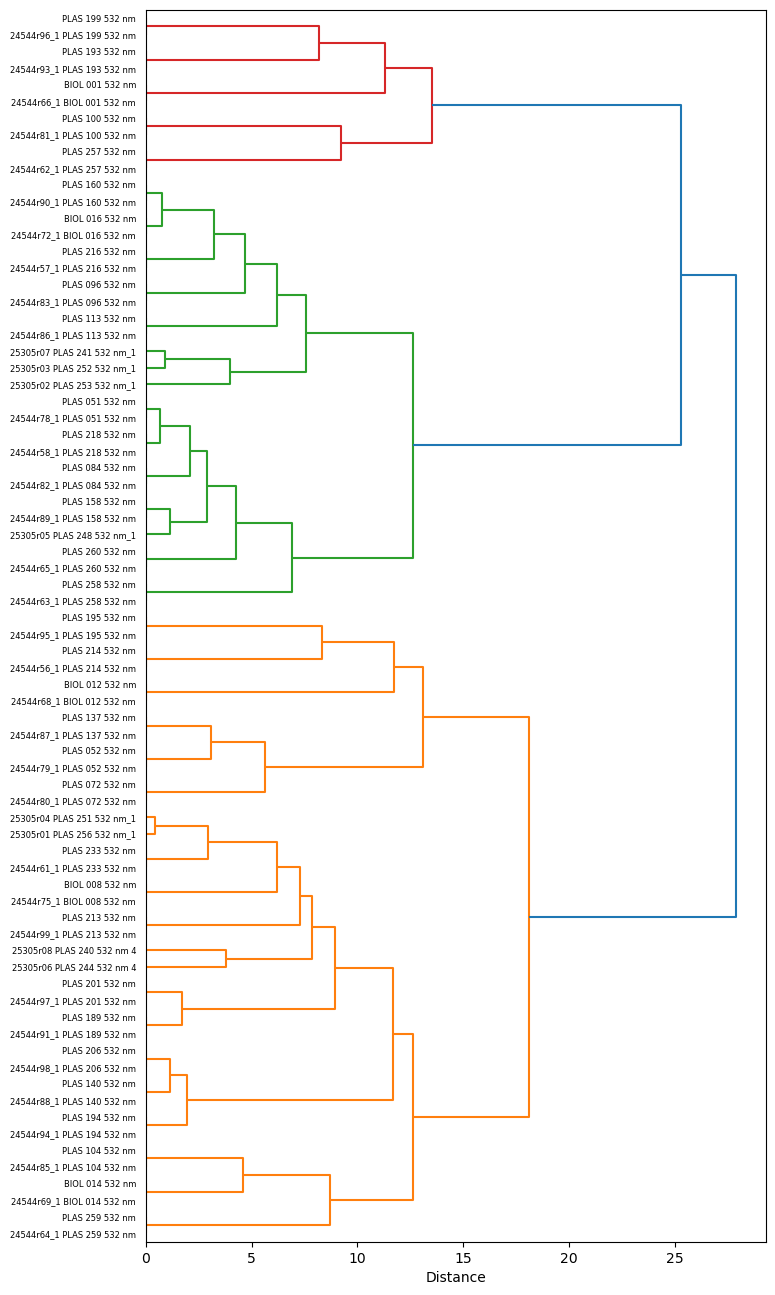

In [10]:
plt.figure(figsize=(8, 16))

# 階層クラスタリング
linkage_matrix = linkage(df, method='ward')

dendrogram(linkage_matrix, 
           labels=df.index, 
           orientation='right',
           color_threshold=20.0,
          )

plt.xlabel('Distance')

plt.show()

### ポイント
データセットのクラスタリング構造を視覚的に理解するために非常に有用で、デンドログラムにより、データの階層的なグルーピングやクラスター間の距離関係を直感的に把握できます。

#### 【解説】`linkage()`関数および`dendrogram()`関数

階層クラスタリングの結果を可視化するために使用される関数です。階層クラスタリングは、データポイントを階層的に類似度に基づいてグループ化する手法ですが、dendrogram関数は、そのクラスタリングの結果をデンドログラムとして描画します。

以下は、`dendrogram`関数の基本的な使い方の例です。

```python
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# サンプルデータ生成
np.random.seed(0)
data = np.random.rand(10, 2)

# 階層クラスタリングの実行
linkage_matrix = linkage(data, method='ward')

# デンドログラムの描画
plt.figure(figsize=(8, 6))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()
```

この例では、`numpy`を使ってランダムな2次元データを生成し、`scipy.cluster.hierarchy`モジュールから`dendrogram`と`linkage`関数を使用して階層クラスタリングを行っています。`linkage`関数では、クラスタリングの方法として"ward"法（ウォード法）が使用されていますが、他にも様々な方法があります（"single"、"complete"、"average"など）。

`dendrogram`関数は、階層クラスタリングの結果を受け取り、デンドログラムを描画します。x軸はデータポイント、y軸は距離を表しており、クラスタのマージがどのように進行しているかが可視化されます。

### 5.2 主成分分析（Principal Component Analysis, PCA）

次にスペクトル類似を主成分分析（Principal Component Analysis, PCA）で次元削減を行ったのちにK-means法でクラスタリングを行う流れを検討します。以下は目的と期待効果の一例です。

* プラスチックのラマンスペクトルデータは多次元の情報を含んでいますが多量のスペクトルを比較することは人間には困難です。PCAは相互に依存する変数を線形変換によって無相関な主成分に変換することで、データの次元を低減します。PCAによって得られた主成分は、元のデータの大部分の分散を保持しつつ、可視化や解析が容易になります。  

* PCAを使用してデータを主成分空間に射影することで、データ間の類似性を捉えることができます。K-meansクラスタリングは、射影された主成分空間内で類似したデータポイントをグループ化します。この結果、ラマンスペクトルの類似性に基づいてプラスチック粒子をクラスタリングすることができます。

* K-meansクラスタリングは、あらかじめ指定したクラスタ数（K）に基づいてデータをグループ化します。プラスチックのラマンスペクトルをK-meansでクラスタリングすると、異なる種類や由来のプラスチックが異なるクラスタに集まる可能性があります。これによって、プラスチックの分類や特定の種類のプラスチックの存在を検出するのに役立つ可能性があります。

### HCA用のライブラリの読み込み

In [11]:
from sklearn.decomposition import PCA

3318次元のデータ行列（df）を2つの主成分（2次元）に次元削減します。

In [12]:
# PCAによる次元削減
pca = PCA(n_components=2)
pca.fit(df)
df_t = pca.transform(df)

主成分分析された第1主成分と第2主成分のプロットは、df_tをpandasのdataframe型へ変換をかけてseabornの`scatterplot()`関数で出力します。

In [13]:
df_pca = pd.DataFrame(df_t)

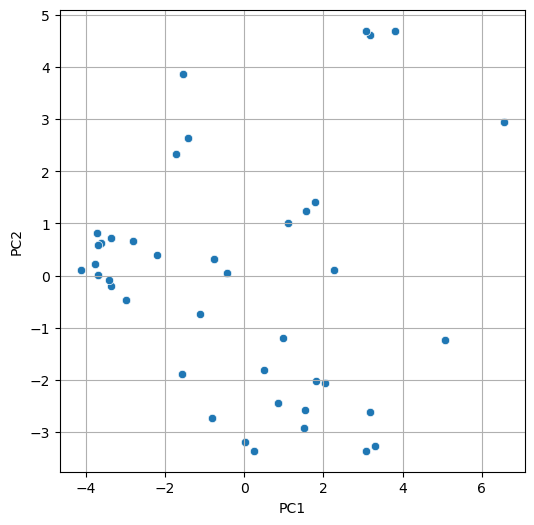

In [14]:
fig, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(data=df_pca,
                x=df_pca[0], 
                y=df_pca[1]
               )
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.grid()
plt.show()

### K-means分析（エルボー法によるクラスタ数の算定）

K-meansクラスタリングは、与えられたデータを指定された数のクラスタに分割する手法です。エルボー法（Elbow Method）は、K-meansクラスタリングにおいて適切なクラスタ数を選択するための一般的なアプローチの一つです。

エルボー法のアイデアは、異なるクラスタ数を試して、クラスタ内のばらつき（クラスタ内誤差平方和；SSE：Sum of Squared Error）がどれだけ小さくなるかを評価することです。クラスタ内の誤差平方和は、各データ点とそのクラスタの重心との距離の二乗の合計を示します。これより、誤差平方和が小さい値ほど各データ点がそのクラスタの中に集まっていることを示します。

エルボー法の手順：

1. 異なるクラスタ数（Kの値）を試して、それぞれのクラスタリング結果のクラスタ内誤差平方和を計算。
1. 各クラスタ数に対するクラスタ内誤差平方和（SSE）をプロット。
1. プロットを見て、誤差平方和（SSE）の減少率が急速で減少が鈍化するタイミング（肘部分）を探索。
1. エルボー（肘部分）が見つかったクラスタ数を選択。

この肘部分は、クラスタ数が増加するにつれて、誤差平方和（SSE）の減少率が緩やかになるため、最適なクラスタ数を示すことがあります。  
エルボー法は、クラスタ数を選択するためのヒューリスティックな手法ですが、必ずしも肘部分が明確に見えるわけではなく、実際のデータによっては明らかな肘部分がない場合もあります。そのため、エルボー法を用いつつも、他の方法やドメイン知識と組み合わせて最適なクラスタ数を選択することが重要です。

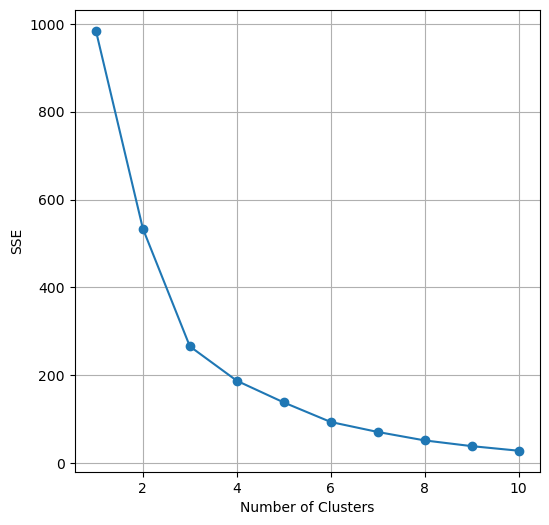

In [15]:
fig, ax = plt.subplots(figsize=(6,6))

#クラスタごとの誤差平方和の格納する
sse = []

for i  in range(1,11):            
    model = KMeans(n_clusters=i, random_state=42)
    model.fit(df_pca)                         
    sse.append(model.inertia_)  


ax.plot(range(1,11),sse,marker='o')

ax.set_xlabel('Number of Clusters')
ax.set_ylabel('SSE')

plt.grid()
plt.show()

### クラスタ表示

K-meansクラスタリングを使用してデータを3クラスタに分割しましょう。PCAによる次元削減を行っているため、元の特徴空間の次元よりも低次元でクラスタリングが行われています。

In [16]:
# クラスタ数
k = 3

model = KMeans(n_clusters = k, 
               random_state=42
              )

model.fit(df_t)
pred = model.predict(df_t)

df_pca["label"] = pred

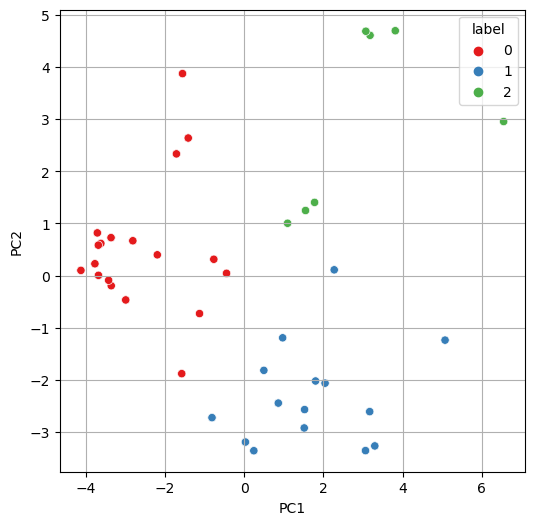

In [17]:
fig, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(data=df_pca,
                x=df_pca[0], 
                y=df_pca[1],
                hue="label",
                palette="Set1"
               )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.grid()
plt.show()

### ファイル名（スペクトルラベル）の付与
各プロットについてどのスペクトルからの主成分値であるかをラベリング（アノテーション）を行います。

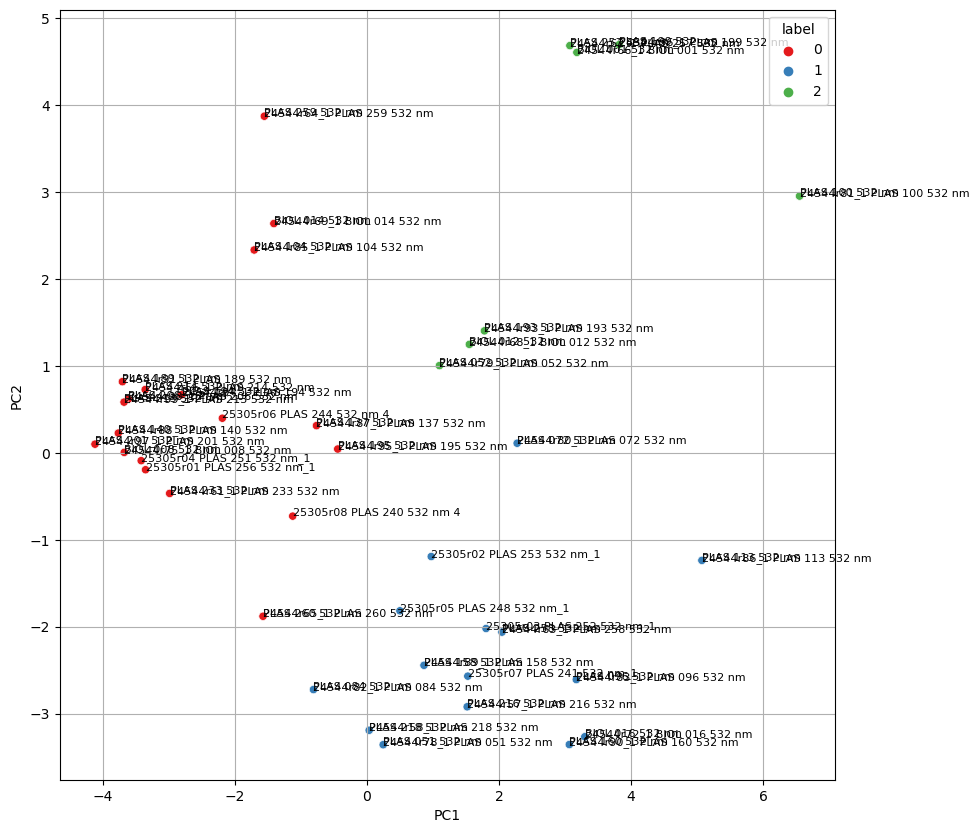

In [18]:
# 可視化

fig, ax = plt.subplots(figsize=(10,10))

df_pca["label"] = pred

sns.scatterplot(data=df_pca,
                x=df_pca[0], 
                y=df_pca[1],
                hue="label",
                palette="Set1"
               )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

data_x = df_pca[0]
data_y = df_pca[1]

labels = df.index


for x, y, l in zip(data_x, data_y, labels):
    #ax.plot(x, y, marker='o', linestyle='', ms=2, color='blue')
    plt_text = ax.annotate(l, (x, y), fontsize=8, color='black')

plt.grid()
plt.show()

### ファイル名（スペクトルラベル）の付与（ラベル重複の回避）
ラベル重複を回避するため、ここでは`adjustText`ライブラリにある`adjust_text`メソッドを利用します。

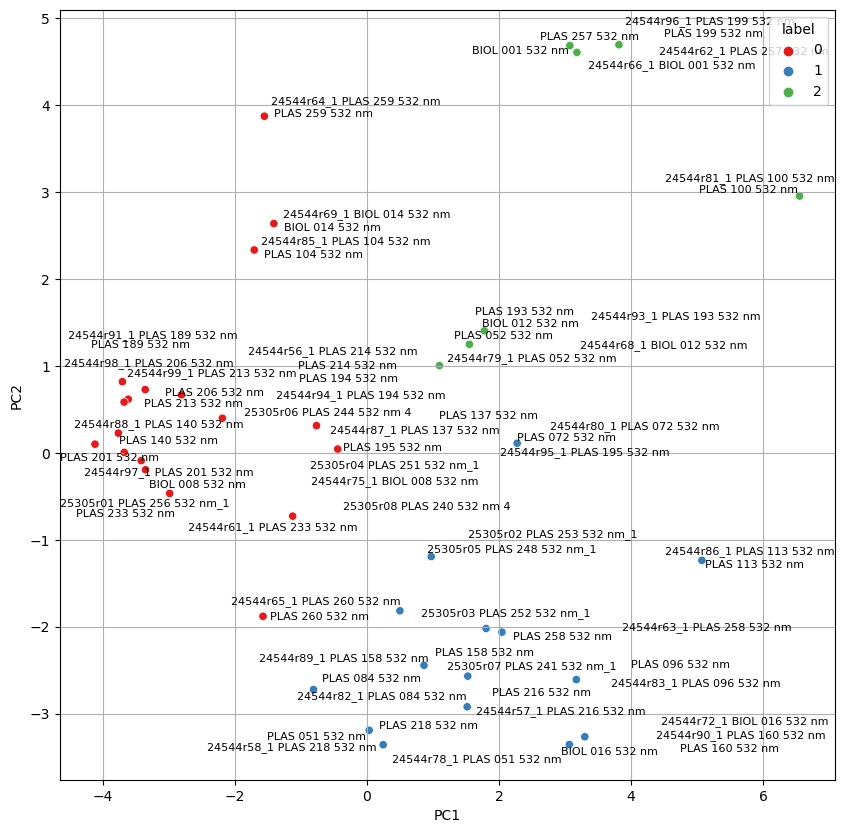

In [19]:
# 可視化
from adjustText import adjust_text

texts = []
fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(data=df_pca,
                x=df_pca[0], 
                y=df_pca[1],
                hue="label",
                palette="Set1"
               )
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

data_x = df_pca[0]
data_y = df_pca[1]
labels = df.index

for x, y, l in zip(data_x, data_y, labels):
    plt_text = ax.annotate(l, (x, y), fontsize=8, color='black')
    texts.append(plt_text)
 
adjust_text(texts)
plt.grid()
plt.show()

### ファイル名（スペクトルラベル）の付与（矢印付き）
`adjust_text`メソッドのarrowpropsの引数で、arrowstyleを指定することでアノテーションとポイントを矢印で結びつけることができます。

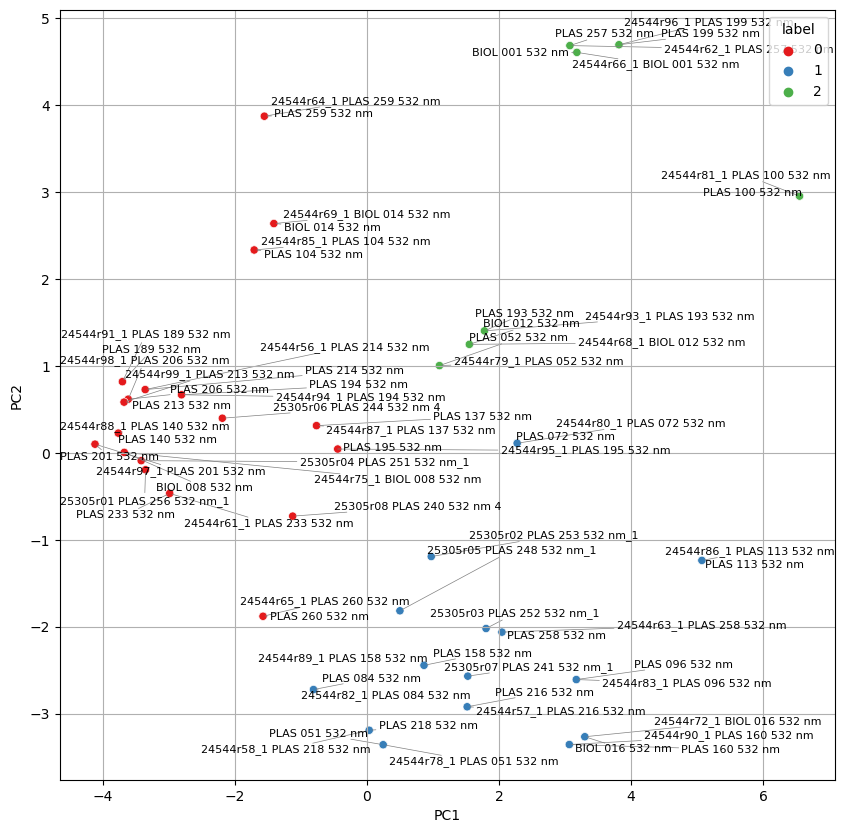

In [20]:
# 可視化
from adjustText import adjust_text

texts = []
fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(data=df_pca,
                x=df_pca[0], 
                y=df_pca[1],
                hue="label",
                palette="Set1"
               )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

data_x = df_pca[0]
data_y = df_pca[1]
labels = df.index

for x, y, l in zip(data_x, data_y, labels):
    plt_text = ax.annotate(l, (x, y), fontsize=8, color='black')
    texts.append(plt_text)
 
# arrowpropsでラベルからプロットした点を指す線などの形状や色を指定
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.grid()
plt.show()